# Tests! (does my code work?)

## Test construtors in POMDP

In [1]:
using Plots
using Distributions
using Statistics
theme(:solarized)

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1278


In [2]:
include("POMDPs.jl")

Main.POMDPs

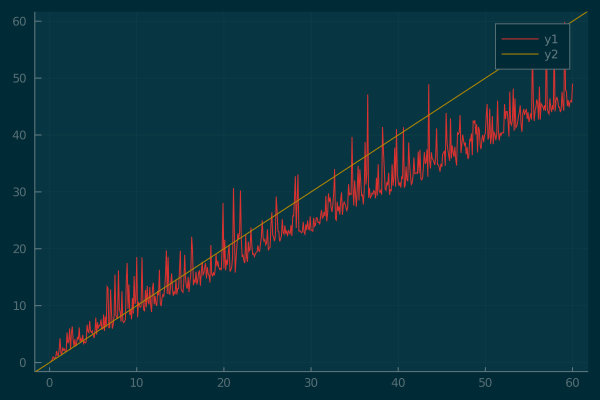

In [3]:
include("Examples.jl")
function T!(x,f)
    Examples.partially_observed_fishery_T!(x,f,Examples.partiallyObservedFishery_pars)
end
R = (x,f) -> Examples.partially_observed_fishery_R!(x,f,Examples.partiallyObservedFishery_pars)
G = (y,x,f) -> Examples.partially_observed_fishery_G(x,y,f,Examples.partiallyObservedFishery_pars)
G_sim = (x,f) -> Examples.partially_observed_fishery_G_sim(x,f,Examples.partiallyObservedFishery_pars)
delta = 0.93
partiallyObservableFishery = POMDPs.init(T!, R, G_sim, G, delta,1, [[1.0]])

x = log.(0.1:0.1:60)
x_copy = log.(0.1:0.1:60)
y = broadcast(x -> partiallyObservableFishery.T!([x], [0.0])[1] ,x)
Plots.plot(exp.(x_copy),exp.(y) )
Plots.abline!(1,0)

# Test `ParticleFilters.jl`
To start use base methods for patially observed systems

In [53]:
import Pkg; Pkg.add("StatsBase")
include("ParticleFilters.jl")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
   Updating registry at `~/.julia/registries/JuliaComputingRegistry`
  Resolving package versions...
Updating `~/.julia/environments/v1.5/Project.toml`
  [2913bbd2] + StatsBase v0.33.14
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


Main.ParticleFilters

## Initalize a particle filter object

In [54]:

PF = ParticleFilters.init(500,1) # generate particle filter object
prior = Distributions.Normal(3.5,0.5) # set prior distribution
broadcast(i -> PF.samples[i] .= rand(prior,1)[1], 1:PF.N) # sample from prior
print(" ")

# Generate a time series of observaitons 

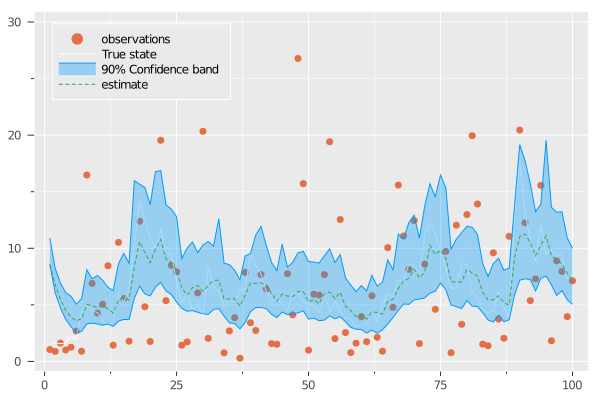

In [55]:
x = [0.5]
t_ = 100
yt = broadcast(i -> zeros(2),1:t_)
xt = zeros(t_)
for t in 1:t_
    xt[t] = x[1]
    yt[t] .= partiallyObservableFishery.G_sim(x,[0.1])
    partiallyObservableFishery.T!(x, [0.1])
end 
# plot observations and true abundnaces 
p1 = Plots.scatter(broadcast(i -> exp(yt[i][1]),1:t_), color = 2, ylim = [0,30], label = "observations")
p1 = Plots.plot!(p1, exp.(xt), color = "white", label = "True state")

x_hat, x_lower, x_upper = zeros(t_), zeros(t_), zeros(t_)
for t in 1:t_
    ParticleFilters.bayes_update!(PF,partiallyObservableFishery.G,yt[t],[0.1])
    ParticleFilters.resample!(PF)
    x_hat[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.5)
    x_lower[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.05)
    x_upper[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.95)
    ParticleFilters.time_update!(PF,partiallyObservableFishery.T!,[0.1])
end 


p1 = Plots.plot!(p1,exp.(x_lower), fillrange = exp.(x_upper), 
    fillalpha = 0.35,  c = 1,
    label = "90% Confidence band", legend = :topleft)
p1 = Plots.plot!(p1,exp.(x_upper), c=1, label = "")
p1 = Plots.plot!(p1, exp.(x_hat), c = 3, linestyle =:dash, label = "estimate")
p1

# Test unscented Kalman Filters

## Initailize `POMDP_KalmanFilter`

In [56]:
# load KalmandFilters.jl and Examples.jl
using KalmanFilters
include("Examples.jl")
include("POMDPs.jl")
# initianize POMDP object
T_! = (x,f) -> Examples.unknown_growth_rate_T!(x,f,(0.2,0.1))
T_ = (x,f) -> Examples.unknown_growth_rate_T(x,f,(0.2,0.1))
R = (x,f) -> sum(x)
Sigma_N = Examples.Sigma_N
H = (x,a) -> Examples.H * x
Sigma_O = reshape(Examples.Sigma_O,1,1)
delta = 0.95
unknownGrowthRate = POMDPs.init(T_!,T_,R,H,Sigma_N,Sigma_O,delta, 1)
print(" ")

## Comapre Particle filter and Kalman filter resutls

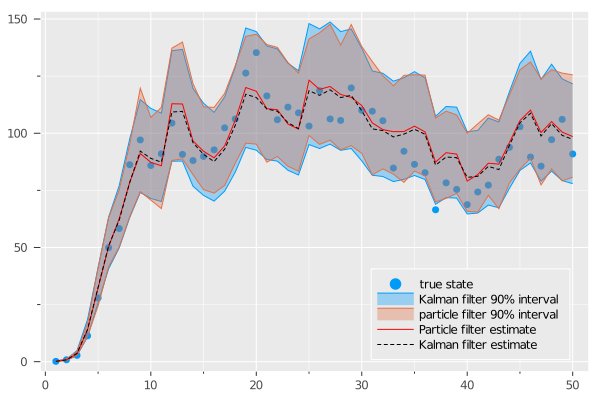

In [57]:

#### generate time series ####
N_ = 50
yt = zeros(N_)
xt = zeros(N_)
x = [-3.5,1.5]
for t in 1:N_
    x = unknownGrowthRate.T_sim!(x,[0.1])
    xt[t] = x[1]
    yt[t] = unknownGrowthRate.G_sim(x,[0.1])[1]
end 
#p1 = Plots.scatter(exp.(yt), c=1)
p1 = Plots.scatter(exp.(xt), c = 1, label = "true state")
p1


#### initalize filters ####
# prior distribution 
x0, P0 = [-3.5,1.5],[1.0 0.0; 0.0 0.0025]

# init particle filter
PF = ParticleFilters.init(1000,2) # generate particle filter object
prior = Distributions.MvNormal(x0,P0) # set prior distribution
broadcast(i -> PF.samples[i] .= reshape(rand(prior,1),2), 1:PF.N) # sample from prior

# step 1 to init KalmanFilter object
uKF = KalmanFilters.time_update(x0,P0,
                    x ->unknownGrowthRate.T(x,[0.1]),  unknownGrowthRate.Sigma_N)

uKF = KalmanFilters.measurement_update(get_state(uKF),get_covariance(uKF),yt[1],
                    x ->  unknownGrowthRate.H(x,[0.1]),unknownGrowthRate.Sigma_O)

# update Particle Filter
ParticleFilters.time_update!(PF,unknownGrowthRate.T_sim!,[0.1])
ParticleFilters.bayes_update!(PF,unknownGrowthRate.G,yt[1],[0.1])
ParticleFilters.resample!(PF)
print(" ")


x = get_state(uKF)
P = get_covariance(uKF)

### accumulators ###

# kalman filter
x_hat = zeros(N_)
a_hat = zeros(N_)
x_lower, x_upper = zeros(N_),zeros(N_)
a_lower, a_upper = zeros(N_),zeros(N_)

x_hat[1] = x[1]
a_hat[1] = x[2]

x_lower[1], x_upper[1] = x[1] - 2*sqrt(P[1,1]), x[1] + 2*sqrt(P[1,1])
a_lower[1], a_upper[1] = x[2] - 2*sqrt(P[2,2]), x[2] + 2*sqrt(P[2,2])

# particle filter
x_hat_pf = zeros(N_)
a_hat_pf = zeros(N_)
x_lower_pf, x_upper_pf = zeros(N_),zeros(N_)
a_lower_pf, a_upper_pf = zeros(N_),zeros(N_)

x_hat_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.5)
a_hat_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.5)

x_lower_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.025)
x_upper_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.975)
a_lower_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.025)
a_upper_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.975)

#### iterate ove time series ####
for t in 2:N_
    # update Kalman Filter
    uKF = KalmanFilters.time_update(get_state(uKF),get_covariance(uKF),
                        x ->unknownGrowthRate.T(x,[0.1]),  unknownGrowthRate.Sigma_N)
    
    uKF = KalmanFilters.measurement_update(get_state(uKF),get_covariance(uKF),yt[t],
                           x ->  unknownGrowthRate.H(x,[0.1]),unknownGrowthRate.Sigma_O)
    
    
    # update Particle Filter
    ParticleFilters.time_update!(PF,unknownGrowthRate.T_sim!,[0.1])
    ParticleFilters.bayes_update!(PF,unknownGrowthRate.G,yt[t],[0.1])
    ParticleFilters.resample!(PF)
    
    
    
    x = get_state(uKF)
    P = get_covariance(uKF)
    x_hat[t] = x[1]
    a_hat[t] = x[2]

    x_lower[t], x_upper[t] = x[1] - 2*sqrt(P[1,1]), x[1] + 2*sqrt(P[1,1])
    a_lower[t], a_upper[t] = x[2] - 2*sqrt(P[2,2]), x[2] + 2*sqrt(P[2,2])
    
    # particel filter data     
    x_hat_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.5)
    x_lower_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.025)
    x_upper_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.975)
    
    
    a_hat_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.5)
    a_lower_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.025)
    a_upper_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.975)
end 


p1 = Plots.plot!(p1,exp.(x_lower), fillrange = exp.(x_upper), 
    fillalpha = 0.35,  c = 1,
    label = "Kalman filter 90% interval", legend = :topleft)
p1 = Plots.plot!(p1,exp.(x_upper), c=1, label = "")


p1 = Plots.plot!(p1,exp.(x_lower_pf), fillrange = exp.(x_upper_pf), 
    fillalpha = 0.35,  c = 2,
    label = "particle filter 90% interval", legend = :topleft)
p1 = Plots.plot!(p1,exp.(x_upper_pf), c=2, label = "")
p1 = Plots.plot!(p1, exp.(x_hat_pf), color = "red", label = "Particle filter estimate",legend =:bottomright)
p1 = Plots.plot!(p1, exp.(x_hat), color = "black", linestyle =:dash, label = "Kalman filter estimate")

p1

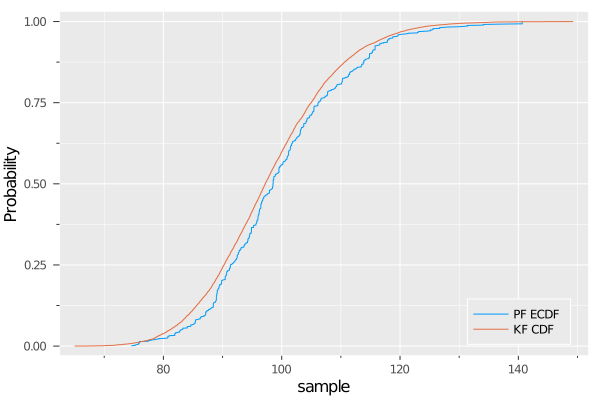

In [58]:
x1 = broadcast(x -> x[1], PF.samples)
n = length(x1)

p2 = Plots.plot(sort(exp.(x1)), (1:n)./n, 
    xlabel = "sample", ylabel = "Probability", 
     label = "PF ECDF")
d = Distributions.Normal(x[1],sqrt(P[1,1]))
x1 = rand(d, 10000)
n = length(x1)
Plots.plot!(sort(exp.(x1)), (1:n)./n, 
    xlabel = "sample", ylabel = "Probability", 
    label = "KF CDF",legend =:bottomright)
p2

In [59]:

function KalmanFilter(y)
    uKF = KalmanFilters.time_update(x0, P0,
                            x ->unknownGrowthRate.T(x,[0.1]),  unknownGrowthRate.Sigma_N)

    uKF = KalmanFilters.measurement_update(get_state(uKF),get_covariance(uKF),y,
                               x ->  unknownGrowthRate.H(x,[0.1]),unknownGrowthRate.Sigma_O)
end 

function ParticleFilter(y)
    ParticleFilters.time_update!(PF,unknownGrowthRate.T_sim!,[0.1])
    ParticleFilters.bayes_update!(PF,unknownGrowthRate.G,y,[0.1])
    #ParticleFilters.resample!(PF)
end 

KalmanFilter(yt[40])
ParticleFilter(yt[40])
print(" ")

@time ParticleFilter(yt[40])
@time KalmanFilter(yt[40])

   0.001122 seconds (16.00 k allocations: 985.500 KiB)
  0.000053 seconds (110 allocations: 8.156 KiB)


KalmanFilters.SPMeasurementUpdate{Array{Float64,1},Array{Float64,2},KalmanFilters.TransformedSigmaPoints{Float64,Array{Float64,1},Array{Float64,2},WanMerweWeightingParameters},Array{Float64,1},Array{Float64,2},Array{Float64,2}}([3.6778456303106886, 1.512185782219265], [0.04763401531379896 0.00010444571747085735; 0.00010444571747085778 0.002595389273668302], [-1.879660707898438 -1.8782418051455292 … -1.8810796106513468 -1.879660707898438], [5.833548045024177], [1.0566425110771256], [0.9526803062759541; 0.0020889143494171015])

In [60]:
0.0025/0.00008


31.249999999999996

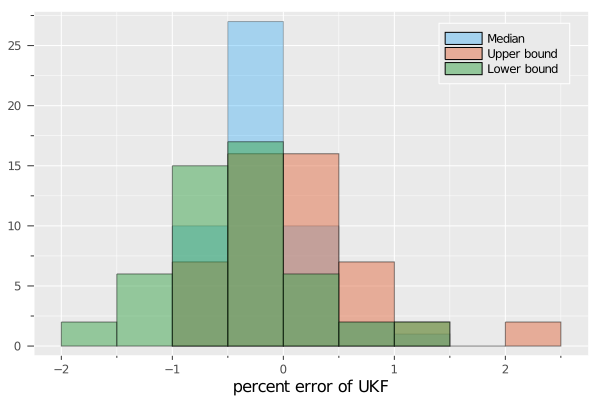

In [61]:
Plots.histogram(100 *(x_hat .- x_hat_pf)./mean(x_hat_pf),
    xlab = "percent error of UKF", label = "Median", alpha = 0.3)
Plots.histogram!(100 *(x_upper .- x_upper_pf)./mean(x_upper_pf), 
    label = "Upper bound", alpha = 0.5)
Plots.histogram!(100 *(x_lower .- x_lower_pf)./mean(x_lower_pf), 
    label = "Lower bound", alpha = 0.5)

In [62]:
#tu = KalmanFilters.time_update(get_state(uKF),get_covariance(uKF),
#                        x ->unknownGrowthRate.T(x,[0.1]),  unknownGrowthRate.Sigma_N)
    
#mu = KalmanFilters.measurement_update(get_state(uKF),get_covariance(uKF),yt[1],
#                        x ->  unknownGrowthRate.H(x,[0.1]),unknownGrowthRate.Sigma_O)

mu

2×1 Array{Float64,2}:
 2.25077044783166
 1.2446591518008023

# Test `MvGaussHermite`
## to solveintegrals for bellman opperator

In [70]:
import Pkg; Pkg.add("FastGaussQuadrature")

  Resolving package versions...
  Installed FastGaussQuadrature ─ v0.4.9
Updating `~/.julia/environments/v1.5/Project.toml`
  [442a2c76] + FastGaussQuadrature v0.4.9
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [442a2c76] + FastGaussQuadrature v0.4.9


In [71]:
using FastGaussQuadrature
using LinearAlgebra
using IterTools
include("MvGaussHermite.jl")

┌ Info: Precompiling FastGaussQuadrature [442a2c76-b920-505d-bb47-c5924d526838]
└ @ Base loading.jl:1278


Main.MvGaussHermite

# Test 2 dimensional GH quadrature 

In [72]:
Cov = [0.25 -0.2;-0.2 0.3] .* 2.0
m = 4
Quad = MvGaussHermite.init(m, [0,0.0],Cov)

Main.MvGaussHermite.quadrature([0.01605018360933761, 0.04668426114935483, 0.04668426114935483, 0.01605018360933761, 0.04668426114935483, 0.13578786960376119, 0.13578786960376119, 0.04668426114935483, 0.04668426114935483, 0.13578786960376119, 0.13578786960376119, 0.04668426114935483, 0.01605018360933761, 0.04668426114935483, 0.04668426114935483, 0.01605018360933761], AbstractArray{Float64,1}[[1.5082680645200224, -1.7085392442759781], [1.2225977965107804, -0.9238325769074363], [0.9563954851739278, -0.19260237213097525], [0.6707252171646858, 0.5921042952375665], [0.7650540346530617, -1.327744074078104], [0.47938376664381965, -0.5430374067095622], [0.21318145530696717, 0.18819279806689887], [-0.07248881270227481, 0.9728994654354406], [0.07248881270227481, -0.9728994654354406], [-0.21318145530696717, -0.18819279806689887], [-0.47938376664381965, 0.5430374067095622], [-0.7650540346530617, 1.327744074078104], [-0.6707252171646858, -0.5921042952375665], [-0.9563954851739278, 0.1926023721309752

┌ Warning: Multiple series with different levels share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /Users/johnbuckner/.julia/packages/Plots/SjqWU/src/backends/gr.jl:498
┌ Warning: Multiple series with different levels share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /Users/johnbuckner/.julia/packages/Plots/SjqWU/src/backends/gr.jl:498


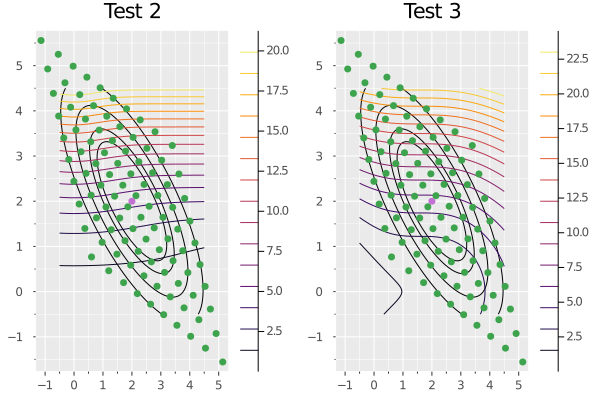

In [73]:

# prune 
theta = 0.00001 / m^2
# covariance matrix and transform
y_hat = [2.0,2.0]
Cov = [0.25 -0.2;-0.2 0.3] .* 2.0
m = 10
Quad = MvGaussHermite.init(m,y_hat , Cov)


nodes_x = broadcast(i -> Quad.nodes[i][1], 1:Quad.n)
nodes_y = broadcast(i -> Quad.nodes[i][2], 1:Quad.n)

xs = -0.5:0.025:4.5
ys = -0.5:0.025:4.5
dsn = Distributions.MvNormal(y_hat, Cov)
pdf_ = (x,y) -> pdf(dsn, [x,y])
function ftest1(x)
    return x[1]+x[2] + x[1]*x[2] + x[1]^2
end 

function ftest2(x)
    return sum(sin(4*x[1]*x[2])*cos(x[2])+x[1])
end 

function ftest2(x)
    return exp(-0.05*(x[1]*x[2])^2)
end 

function ftest3(x)
    return sum(x[1]+x[2]^2 + cos(3*x[2]*x[1]))
end 
        
        
function ftest2(x,y)
    x = [x,y]
    return exp(-0.05*(x[1]*x[2])^2) + x[2]^2
end 
            
function ftest3(x,y)
    x = [x,y]
    return sum(x[1]+x[2]^2 + cos(x[1]))
end 
p1 = Plots.contour(xs, ys, pdf_, fill=false, levels = [0.1,0.01,0.05,0.001])
Plots.contour!(xs, ys, ftest2, fill=false)

Plots.scatter!(nodes_x,nodes_y)
Plots.scatter!([y_hat[1]], [y_hat[2]], legend = false, title = "Test 2")

p2 = Plots.contour(xs, ys, pdf_, fill=false, levels = [0.1,0.01,0.05,0.001])
Plots.contour!(xs, ys, ftest3, fill=false)

Plots.scatter!(nodes_x,nodes_y)
Plots.scatter!([y_hat[1]], [y_hat[2]], legend = false, title = "Test 3")
plot(p1,p2)

## Compare computed expctations for three test functions
### using `MvGaussHermite.jl` and Montecarlo integration

In [74]:
### compare montecarlo and Gauss Hermite 
# function 1
N_mc = 100000
mcf1 = sum(ftest1.(broadcast(i -> rand(dsn, 1), 1:N_mc)))/N_mc
ghf1 = MvGaussHermite.expected_value(ftest1, Quad)
print("test one Montecarlo: " , mcf1, "\n")
print("test one Gauss Hermite: " , ghf1, "\n")
print("percent diference: " , round((mcf1-ghf1)/mcf1*100,digits = 2), "% \n")
print("\n")
# function 2
mcf2 = sum(ftest2.(broadcast(i -> rand(dsn, 1), 1:N_mc)))/N_mc
ghf2 = MvGaussHermite.expected_value(ftest2, Quad)
print("test two Montecarlo: " , mcf2, "\n")
print("test two Gauss Hermite: " , ghf2, "\n")
print("percent diference: " ,round( (mcf2-ghf2)/mcf2*100, digits = 2), "% \n")
print("\n")
# function 3
mcf3 = sum(ftest3.(broadcast(i -> rand(dsn, 1), 1:N_mc)))/N_mc
ghf3 = MvGaussHermite.expected_value(ftest3, Quad)
print("test three Montecarlo: " , mcf3, "\n")
print("test three Gauss Hermite: " , ghf3, "\n")
print("percent diference: " , round((mcf3-ghf3)/mcf3*100, digits = 2), "% \n")
print("\n")

test one Montecarlo: 12.105449410867726
test one Gauss Hermite: 12.099668942967625
percent diference: 0.05% 

test two Montecarlo: 0.528503463135126
test two Gauss Hermite: 0.5291421452141204
percent diference: -0.12% 

test three Montecarlo: 6.587302387756244
test three Gauss Hermite: 6.592737997889056
percent diference: -0.08% 



## Test 3d quadrature

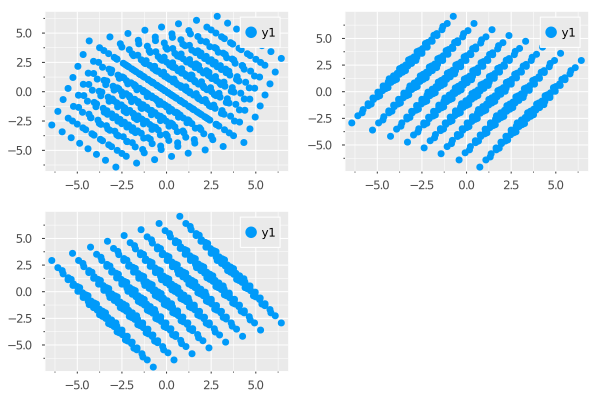

In [75]:
include("MvGaussHermite.jl")
Cov = [2.0 0.5 0.0; 0.5 2.0 0.0; 0.0 0.0 2.0]
y_hat = [0.0, 0.0, 0.0]
m = 8
Quad_3d = MvGaussHermite.init(m, y_hat, Cov)
nodes_x = broadcast(i -> Quad_3d.nodes[i][1], 1:Quad_3d.n)
nodes_y = broadcast(i -> Quad_3d.nodes[i][2]  , 1:Quad_3d.n)
nodes_z = broadcast(i -> Quad_3d.nodes[i][3] , 1:Quad_3d.n)

dsn_3d = Distributions.MvNormal(y_hat, Cov)

p1 = Plots.scatter(nodes_x, nodes_y)
p2 = Plots.scatter(nodes_x, nodes_z)
p3 = Plots.scatter(nodes_y, nodes_z)
plot(p1,p2,p3)

In [76]:
test_f1(x) = x[1]+x[2]+x[3] + x[2]*x[3] +x[2]^2+x[3]^2+x[1]^2
test_f2(x) = x[1]+x[2]+x[3] + sin(2*x[2]*x[3]) + x[1]^2
test_f3(x) = 0.1*x[1]+0.2*x[2]^2+exp(-0.1*x[3]^2) 
Nmc = 1000000
samples = broadcast(i -> rand(dsn_3d, 1), 1:Nmc)
val1_gh = MvGaussHermite.expected_value(test_f1, Quad_3d)
val1_mc = sum(test_f1.(samples))/Nmc 
println("Gauss hermite: ", val1_gh)
println("Montecarlo: ", val1_mc)
println("percent diference: " , round((val1_mc-val1_gh)/val1_mc*100, digits = 2), "%")
print("\n")

val2_gh = MvGaussHermite.expected_value(test_f2, Quad_3d)
val2_mc = sum(test_f2.(samples))/Nmc 
println("Gauss hermite: ", val2_gh)
println("Montecarlo: ", val2_mc)
println("percent diference: " , round((val2_mc-val2_gh)/val2_mc*100, digits = 2), "%")
print("\n")

val3_gh = MvGaussHermite.expected_value(test_f3, Quad_3d)
val3_mc = sum(test_f3.(samples))/Nmc 
println("Gauss hermite: ", val3_gh)
println("Montecarlo: ", val3_mc)
println("percent diference: " , round((val3_mc-val3_gh)/val3_mc*100, digits = 2), "%")
print("\n")

Gauss hermite: 5.984054326519408
Montecarlo: 5.988083103844399
percent diference: 0.07%

Gauss hermite: 2.0265980561616788
Montecarlo: 1.9999997285142872
percent diference: -1.33%

Gauss hermite: 1.2439913359425414
Montecarlo: 1.2446216763790905
percent diference: 0.05%



## Test 4 dimensions 

In [77]:
include("MvGaussHermite.jl")
Cov = [1.0 0.5 0.0 0.0; 0.5 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
y_hat = [0.0, 0.0, 0.0, 0.0]
m = 8
Quad_4d = MvGaussHermite.init(m, y_hat, Cov)
nodes_x = broadcast(i -> Quad_4d.nodes[i][1], 1:Quad_4d.n)
nodes_y = broadcast(i -> Quad_4d.nodes[i][2], 1:Quad_4d.n)
nodes_z = broadcast(i -> Quad_4d.nodes[i][3], 1:Quad_4d.n)
nodes_w = broadcast(i -> Quad_4d.nodes[i][4], 1:Quad_4d.n)

dsn_4d = Distributions.MvNormal(y_hat, Cov)

p1 = Plots.scatter(nodes_x, nodes_y)
p2 = Plots.scatter(nodes_x, nodes_z)
p3 = Plots.scatter(nodes_x, nodes_w)
p4 = Plots.scatter(nodes_y, nodes_z)
p5 = Plots.scatter(nodes_y, nodes_w)
p6 = Plots.scatter(nodes_z, nodes_w)
plot(p1,p2,p3,p4,p5,p6)

In [78]:
test_f1(x) = x[1]+x[2]+x[3] + x[2]*x[3]*x[4] +x[1]^2+x[2]^2+x[3]^2+x[4]^2
test_f2(x) = x[1]+x[2]+x[3] + sin(2*x[2]*x[3]*x[4])
test_f3(x) = exp(-0.1*x[3]+0.1*x[4]) + cos(x[2]*x[1]) + x[4]*x[3]^2+x[2]^2
Nmc = 1000000
samples = broadcast(i -> rand(dsn_4d, 1), 1:Nmc)
val1_gh = MvGaussHermite.expected_value(test_f1, Quad_4d)
val1_mc = sum(test_f1.(samples))/Nmc 
println("Gauss hermite: ", val1_gh)
println("Montecarlo: ", val1_mc)
println("percent diference: " , round((val1_mc-val1_gh), digits = 2))
print("\n")

val1_gh = MvGaussHermite.expected_value(test_f2, Quad_4d)
val1_mc = sum(test_f2.(samples))/Nmc 
println("Gauss hermite: ", val1_gh)
println("Montecarlo: ", val1_mc)
println("percent diference: " , round((val1_mc-val1_gh), digits = 2))
print("\n")

val1_gh = MvGaussHermite.expected_value(test_f3, Quad_4d)
val1_mc = sum(test_f3.(samples))/Nmc 
println("Gauss hermite: ", val1_gh)
println("Montecarlo: ", val1_mc)
println("percent diference: " , round((val1_mc-val1_gh), digits = 2))
print("\n")

Gauss hermite: 3.9889193282634325
Montecarlo: 4.0000767686952905
percent diference: 0.01

Gauss hermite: 1.1102230246251565e-16
Montecarlo: 0.0005291078611559476
percent diference: 0.0

Gauss hermite: 2.68756188460671
Montecarlo: 2.689102769130083
percent diference: 0.0



# Test error propogation through observaton model 

In [79]:
include("BellmanOpperators.jl")
include("MvGaussHermite.jl")
BellmanOpperators.propogate_observation_model([1.0,1.0],[1.0 0.5;0.5 1.0], [1.0 0.1;0.1 1.0])

┌ Warning: Replacing docs for `Main.BellmanOpperators.Policy! :: Tuple{Any,AbstractArray{Float64,1},Function,Any,Any}` in module `Main.BellmanOpperators`
└ @ Base.Docs docs/Docs.jl:227


([1.1, 1.1], [1.11 0.705; 0.705 1.11])

# Test quadrature propogation with linear function
m = 6

In [80]:
m = 6
x_hat = [1.0,1.0]
x_cov = [1.0 0.5; 0.5 1.0]
H_mat = [2.0 0.25;0.25 1.0]
H = x -> H_mat *x
Quad = MvGaussHermite.init_mutable(m, x_hat, x_cov)
mu, Cov = BellmanOpperators.propogate_observation_model(x_hat, x_cov, H, Quad)
println((round.(mu,digits = 4),round.(Cov,digits = 4)))
println(BellmanOpperators.propogate_observation_model(x_hat, x_cov, H_mat))

([2.2453, 1.2474], [4.4808 1.7493; 1.7493 1.289])
([2.25, 1.25], [4.5625 1.78125; 1.78125 1.3125])


In [81]:
m = 5
x_hat = [1.0,1.0]
x_cov = [1.0 0.5; 0.5 1.0]
H_mat = [2.0 0.25;0.25 1.0]
H = x -> H_mat *x
Quad = MvGaussHermite.init_mutable(m, x_hat, x_cov)
mu, Cov = BellmanOpperators.propogate_observation_model(x_hat, x_cov, H, Quad)
println((round.(mu,digits = 4),round.(Cov,digits = 4)))
println(BellmanOpperators.propogate_observation_model(x_hat, x_cov, H_mat))

([2.2358, 1.2421], [4.352 1.6991; 1.6991 1.252])
([2.25, 1.25], [4.5625 1.78125; 1.78125 1.3125])


## Test against non-linear function

In [82]:
include("BellmanOpperators.jl")
include("MvGaussHermite.jl")
include("utils.jl")
f(x) = sin(0.5*x)+0.1*x^2+x
#H = x -> [f(([1.0 1.0] * x)[1])]
mu, Cov = BellmanOpperators.propogate_observation_model(x_hat, x_cov, H, Quad)
println((round.(mu,digits = 3),round.(Cov,digits = 3)))

┌ Warning: Replacing docs for `Main.BellmanOpperators.Policy! :: Tuple{Any,AbstractArray{Float64,1},Function,Any,Any}` in module `Main.BellmanOpperators`
└ @ Base.Docs docs/Docs.jl:227


([2.236, 1.242], [4.352 1.699; 1.699 1.252])


In [83]:
Nmc = 10000
d = Distributions.MvNormal(x_hat,x_cov)
sample = broadcast(i -> rand(d,1),1:Nmc)
vals = H.(sample)
mu = sum(broadcast(v -> v/Nmc, vals))
cov = utils.sum_mat(broadcast(v -> (v .- mu)*transpose(v .- mu) ./ Nmc, vals ))
println(mu)
println(cov)

[2.2670880125996478; 1.253540734576781]
[4.522134125380652 1.7892200862170975; 1.7892200862170975 1.3284310040167455]


## Test Value functions 

In [84]:
using Plots
include("ValueFunctions.jl")

Main.ValueFunctions

In [85]:
a = [-4.0,-4.0]
b = [4.0,4.0]
m = 9
p = ValueFunctions.init_interpolation(a,b,m)
print((" "))

In [86]:
g(x) = cos(0.15*x[1]^2+0.15*x[2]^2) 
new_values = g.(p.grid)
ValueFunctions.update_interpolation!(p, new_values)
print(" ")

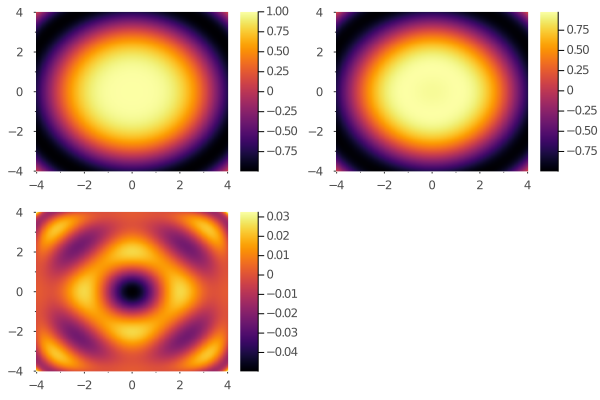

In [87]:
# define grid for plots
x = a[1]:0.05:b[1]
y = a[2]:0.05:b[2]
xy = collect(Iterators.product(x,y))

# calculate true values
v_true = g.(xy)


# reshape xy from an array to a vector and call  evaluate_interpolation
vec_xy = reshape(xy,length(xy))
v_itp = p.(vec_xy)

# convert back to grid for plot
v_itp_grid = reshape(v_itp, length(x), length(y))

# make plots
p1 = Plots.heatmap(y,x,v_true)
p2 = Plots.heatmap(y,x,v_itp_grid)
p3 = Plots.heatmap(y,x,v_itp_grid .- v_true)
plot(p1,p2,p3)#,p3,layout = 3)


# Test `BellmanOpperators.expectation` 
## tests state uncertianty propogation in observaiton model 

In [88]:
include("MvGaussHermite.jl")
include("BellmanOpperators.jl")
# initianize POMDP object
T_! = (x,f) -> Examples.unknown_growth_rate_T!(x,f,(0.2,0.1))
T_ = (x,f) -> Examples.unknown_growth_rate_T(x,f,(0.2,0.1))
R = (x,f) -> sum(x)
Sigma_N = Examples.Sigma_N
H = (x,a) -> Examples.H * x
Sigma_O = reshape(Examples.Sigma_O,1,1)
delta = 0.95
unknownGrowthRate = POMDPs.init(T_!,T_,R,H,Sigma_N,Sigma_O,delta, 1)

# initialize value function 
a = [-1.0,-1.0,0.0,0.0,0.0]
b = [6.0,6.0,1.25,1.25,1.25]
m = 8
p1 = ValueFunctions.init_interpolation(a,b,m)

g(x) = exp(0.5*x[1])+0.2*x[2]-0.05*x[3]-0.05*x[4]+0.01*x[5]^2
new_values = g.(p1.grid)
ValueFunctions.update_interpolation!(p1, new_values)
print(" ")



┌ Warning: Replacing docs for `Main.BellmanOpperators.Policy! :: Tuple{Any,AbstractArray{Float64,1},Function,Any,Any}` in module `Main.BellmanOpperators`
└ @ Base.Docs docs/Docs.jl:227


In [89]:
# init quadrature
m = 5
x_hat = [1.0,1.0]
x_cov = [1.0 0.5; 0.5 1.0]
H_mat = [2.0 0.25;0.25 1.0]
H = x -> H_mat *x
Quad_x = MvGaussHermite.init_mutable(m, x_hat, x_cov)

# init quadrature
m = 10
y_hat = [1.0]
y_cov = [0.5]
H_mat = [1.0 0.0]
H = x -> H_mat *x
Quad_y = MvGaussHermite.init_mutable(m, y_hat, reshape(y_cov,1,1))
print(" ")

In [90]:
# state 
x_hat = [1.0,1.0]
x_cov = [1.0 0.5; 0.5 1.0]
s = BellmanOpperators.reshape_state(x_hat, x_cov)

# action 
a = 1.0

# value function 
a = [-4.0,-4.0,0.0,0.0,0.0]
b = [8.0,8.0,2.0,2.0,2.0]
m = 6
p = ValueFunctions.init_interpolation(a,b,m)
g(x) = cos(0.15*x[1]^2+0.15*x[2]^2) 
new_values = g.(p.grid)
ValueFunctions.update_interpolation!(p, new_values)


V = (x,a) -> p(x)
BellmanOpperators.value_expectation(s,a,V,unknownGrowthRate,Quad_x,Quad_y)

-0.034056517404132056

In [91]:
include("MvGaussHermite.jl")
include("BellmanOpperators.jl")
include("ValueFunctions.jl")

# initialize value function 
a = [-2.0,-2.0,0.0,0.0,0.0]
b = [8.0,8.0,4.0,4.0,4.0]
m = 5
p1 = ValueFunctions.init_interpolation(a,b,m)

g(x) = exp(0.5*x[1])+0.2*x[2]-0.05*x[3]-0.05*x[4]+0.01*x[5]^2
new_values = g.(p1.grid)
ValueFunctions.update_interpolation!(p1, new_values)


x_hat = [1.0,1.0]
x_cov = [1.0 0.5; 0.5 1.0]
s = BellmanOpperators.reshape_state(x_hat, x_cov)
V = (x,a) -> p1(x)
BellmanOpperators.value_expectation(s,a,V,unknownGrowthRate,Quad_x,Quad_y)

┌ Warning: Replacing docs for `Main.BellmanOpperators.Policy! :: Tuple{Any,AbstractArray{Float64,1},Function,Any,Any}` in module `Main.BellmanOpperators`
└ @ Base.Docs docs/Docs.jl:227


5.337940466979253

In [92]:
@time BellmanOpperators.value_expectation(s,a,V,unknownGrowthRate,Quad_x,Quad_y)

  0.000962 seconds (9.16 k allocations: 563.609 KiB)


5.337940466979253

In [93]:

# load KalmandFilters.jl and Examples.jl
using KalmanFilters
include("Examples.jl")
include("POMDPs.jl")
# initianize POMDP object
T_! = (x,f) -> Examples.unknown_growth_rate_T!(x,f,(0.2,0.1))
T_ = (x,f) -> Examples.unknown_growth_rate_T(x,f,(0.2,0.1))
R = (x,f, epsilon) -> sum(vcat(x, epsilon))
Sigma_N = Examples.Sigma_N
H = (x,a) -> Examples.H * x
Sigma_O = reshape(Examples.Sigma_O,1,1)
delta = 0.95
unknownGrowthRateStochasticReward = POMDPs.init(T_!,T_,R,H,Sigma_N,Sigma_O,delta, 1)
print(" ")

In [94]:
include("BellmanOpperators.jl")

# init quadrature
m = 6
x_hat = [1.0,1.0]
x_cov = [1.0 0.5; 0.5 1.0]
H_mat = [2.0 0.25;0.25 1.0]
H = x -> H_mat *x
Quad_x = MvGaussHermite.init_mutable(m, x_hat, x_cov)

# init quadrature
m = 6
y_hat = [1.0]
y_cov = [0.5]
Quad_epsilon = MvGaussHermite.init_mutable(m, y_hat, reshape(y_cov,1,1))

x_hat = [1.0,1.0]
x_cov = [1.0 0.5; 0.5 1.0]
s = BellmanOpperators.reshape_state(x_hat, x_cov)

BellmanOpperators.reward_expectation(s,a,unknownGrowthRateStochasticReward,Quad_x,Quad_epsilon)

┌ Warning: Replacing docs for `Main.BellmanOpperators.Policy! :: Tuple{Any,AbstractArray{Float64,1},Function,Any,Any}` in module `Main.BellmanOpperators`
└ @ Base.Docs docs/Docs.jl:227


2.9906797642599217

In [95]:
@time BellmanOpperators.reward_expectation(s,a,unknownGrowthRateStochasticReward,Quad_x,Quad_epsilon)

  0.000254 seconds (1.40 k allocations: 125.000 KiB)


2.9906797642599217

# Test inplace integration

In [96]:
# state 
x_hat = [1.0,1.0]
x_cov = [1.0 0.7; 0.7 1.0]
s = BellmanOpperators.reshape_state(x_hat, x_cov)



# value function 
a = [-4.0,-4.0,0.0,0.0,0.0]
b = [8.0,8.0,2.0,2.0,2.0]
m = 6
p = ValueFunctions.init_interpolation(a,b,m)
g(x) = cos(0.05*x[1]^2+0.05*x[2]^2+0.01*x[1])+x[3]-0.5*x[4]
new_values = g.(p.grid)
ValueFunctions.update_interpolation!(p, new_values)

# action 
a = 1.0

V = (x,a) -> p(x)
BellmanOpperators.value_expectation(s,[a],V,unknownGrowthRate,Quad_x,Quad_y)

0.9426653296809313

# Test timing and number of allocations 

In [97]:
#include("BellmanOpperators.jl")
data = BellmanOpperators.init_bellmanIntermidiate([0.1], 2, 1, 4, 4)
BellmanOpperators.expectation!(data, s, [a], V, unknownGrowthRate)
BellmanOpperators.MC_expectation(s, [a], unknownGrowthRate, V, 500, 500)
@time BellmanOpperators.expectation!(data, s, [a], V, unknownGrowthRate)
@time BellmanOpperators.MC_expectation(s, [a], unknownGrowthRate, V, 500, 500)

  0.000711 seconds (6.72 k allocations: 415.719 KiB)
  0.857683 seconds (6.73 M allocations: 453.072 MiB, 8.53% gc time)


2.852662159414923

# Compare Monte-Carlo and guasian quadrature 

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

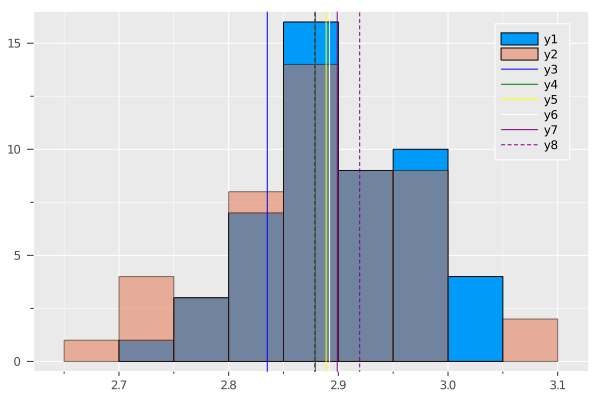

In [98]:
theme(:ggplot2)
data = BellmanOpperators.init_bellmanIntermidiate([0.1], 2, 1, 3, 3)
vals3 = BellmanOpperators.expectation!(data, s, [a], V, unknownGrowthRate)
data = BellmanOpperators.init_bellmanIntermidiate([0.1], 2, 1, 4, 4)
vals4 = BellmanOpperators.expectation!(data, s, [a], V, unknownGrowthRate)
data = BellmanOpperators.init_bellmanIntermidiate([0.1], 2, 1, 5, 5)
vals5 = BellmanOpperators.expectation!(data, s, [a], V, unknownGrowthRate)
data = BellmanOpperators.init_bellmanIntermidiate([0.1], 2, 1, 10, 10)
vals10 = BellmanOpperators.expectation!(data, s, [a], V, unknownGrowthRate)
Nmc = 50
MC_vals = zeros(Nmc)
pf_ukf_vals = zeros(Nmc)
for i in 1:Nmc
    print(i)
    print(" ")
    MC_vals[i] = BellmanOpperators.MC_expectation(s, [a], unknownGrowthRate, V, 500, 500)
    pf_ukf_vals[i] = BellmanOpperators.pf_ukf_expectation(s, [a], unknownGrowthRate, V, 500, 500)
end
Plots.histogram(MC_vals)
Plots.histogram!(pf_ukf_vals, alpha = 0.5)
Plots.vline!([vals3], color = "blue")
Plots.vline!([vals4], color = "green")
Plots.vline!([vals5], color = "yellow")
Plots.vline!([vals10], color = "white")
MC_est = sum(MC_vals)/length(MC_vals)
Mc_se = sqrt(sum((MC_vals .- MC_est).^2)./Nmc) / sqrt(Nmc)
Plots.vline!([MC_est], color = "purple")
Plots.vline!([MC_est+2*Mc_se, MC_est-2*Mc_se], color = "purple", linestyle=:dash)

┌ Warning: Replacing docs for `Main.BellmanOpperators.Policy! :: Tuple{Any,AbstractArray{Float64,1},Function,Any,Any}` in module `Main.BellmanOpperators`
└ @ Base.Docs docs/Docs.jl:227


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

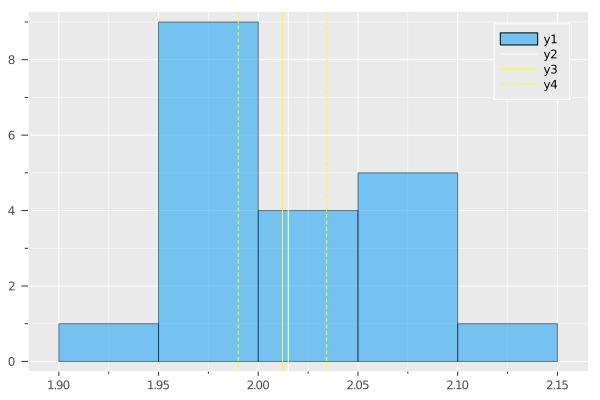

In [103]:
include("BellmanOpperators.jl")
# value function 
a = [-4.0,-4.0,0.0,0.0,0.0]
b = [8.0,8.0,2.0,2.0,2.0]
m = 6
p = ValueFunctions.init_interpolation(a,b,m)
g(x) = cos(0.15*x[1]^2+0.05*x[2]^2 + 0.2*x[1]) 
new_values = g.(p.grid)
ValueFunctions.update_interpolation!(p, new_values)

V = (x,a) -> p(x)

a = 0.1
data = BellmanOpperators.init_bellmanIntermidiate([0.1], 2, 1, 8, 8)
vals = BellmanOpperators.expectation!(data, s, [a], V, unknownGrowthRate)
Nmc = 20
MC_vals = zeros(Nmc)
for i in 1:Nmc
    print(i)
    print(" ")
    MC_vals[i] = BellmanOpperators.MC_expectation(s, [a], unknownGrowthRate, V, 500, 1000)
end
Plots.histogram(MC_vals, alpha = 0.5)
Plots.vline!([vals ], color = "white")
MC_est = sum(MC_vals)/length(MC_vals)
Mc_se = sqrt(sum((MC_vals .- MC_est).^2)./Nmc) / sqrt(Nmc)
Plots.vline!([MC_est], color = "yellow")
Plots.vline!([MC_est+2*Mc_se, MC_est-2*Mc_se], color = "yellow", linestyle=:dash)

In [104]:
include("BellmanOpperators.jl")
actions = [[0.01],[0.05],[0.1],[0.15],[0.2],[0.25],[0.3],[0.35]]
actions = broadcast(i -> [i], 0.01:0.05:0.5)
BellmanOpperators.Bellman!(data, s,actions,
                V, unknownGrowthRate)

@time BellmanOpperators.Bellman!(data, s,actions,
                V, unknownGrowthRate)

┌ Warning: Replacing docs for `Main.BellmanOpperators.Policy! :: Tuple{Any,AbstractArray{Float64,1},Function,Any,Any}` in module `Main.BellmanOpperators`
└ @ Base.Docs docs/Docs.jl:227


  0.010772 seconds (139.32 k allocations: 8.689 MiB)


2.049293189586498

In [106]:
sigma1 = 10
sigma2 = 20
cov = sqrt(sigma1*sigma2) - 0.000001
Distributions.MvNormal([0,0], [sigma1 cov; cov sigma2])


FullNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [10.0 14.142134623730952; 14.142134623730952 20.0]
)


# Test interpolation for covarinace matrix 

In [107]:
function f(mu, cov)
    v1 = mu[1] + 0.3*mu[2] + 0.1*mu[1]*mu[2]
    v1 = v1/(1+v1)
    v2 = cov[1,1] + cov[2,2]
    v2 = -0.05*v2^2
    return v1+v2+0.1*cov[1,2]
end 

f (generic function with 2 methods)

In [192]:
include("ValueFunctions.jl")
m = 5
Vf = ValueFunctions.init_guasianBeleifsInterp2d(m, [-5.0,-5.0],[5.0,5.0])
print(" ")

In [227]:
function test1!(mu)
    return 0.5*mu[2] * mu[1]^2
end 


function test2!(mu, cov)
    v = test1!(mu)
    return v - 0.1*cov[1,1] -0.1*cov[2,2] + 0.05*cov[2,1] +0.05*cov[1,1]*mu[1]
end 

test2! (generic function with 2 methods)

# 

In [264]:
include("ValueFunctions.jl")
m1 = 40
m2 = 7
Vf1 = ValueFunctions.init_adjGausianBeleifsInterp(m1, m2, [-5.0,-5.0],[5.0,5.0])
print(" ")

In [265]:
v1 = 1.0*zeros(m1^2)
v2 = 1.0*zeros(m2^5)
v_mu = broadcast(i->test1!(Vf1.baseValue.grid[i]), 1:m1^2)
v_dsn = broadcast(i->test2!(Vf1.uncertantyAdjustment.nodes[i][1],Vf1.uncertantyAdjustment.nodes[i][2]), 1:m2^5)
print(" ")

In [266]:
ValueFunctions.update_base!(Vf1,v_mu)
ValueFunctions.update_adjustment!(Vf1, v_dsn)
print(" ")

In [267]:
z = zeros(5)
Vf1(z,[2.0,2.0], [0.1 0.01; 0.01 0.1])

3.9899187767026008

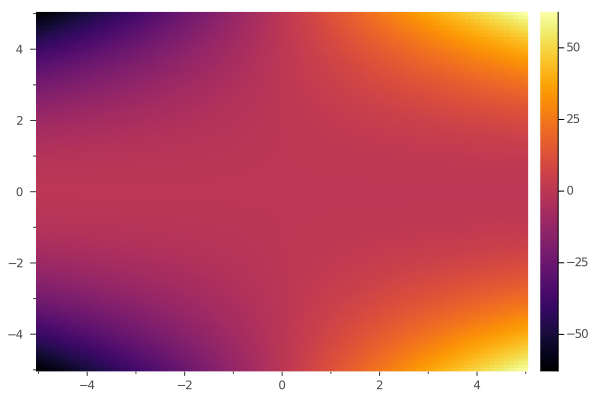

In [268]:
# define grid for plots
x = -5:0.1:5
y = -5:0.1:5
xy = collect(Iterators.product(x,y))




# reshape xy from an array to a vector and call  evaluate_interpolation
vec_xy = reshape(xy,length(xy))
v_itp = broadcast(x -> Vf1(z, [x[1],x[2]], [1.1 0.1; 0.1 1.1]), vec_xy)
v_true = broadcast(x -> test2!([x[1],x[2]], [1.1 0.1; 0.1 1.1]), vec_xy)
# convert back to grid for plot
v_itp_grid = reshape(v_itp, length(x), length(y))

# make plots
p1 = Plots.heatmap(y,x,v_itp_grid)
p1

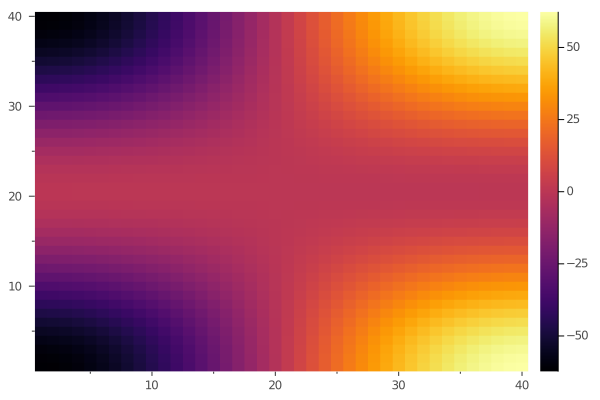

In [269]:
Plots.heatmap(reshape(v_mu,m1,m1))

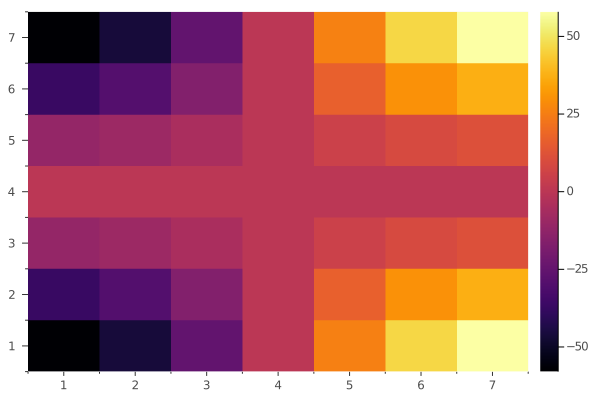

In [270]:
Plots.heatmap(reshape(v_dsn,m2,m2,m2,m2,m2)[:,:,1,1,1])

In [256]:
Vf.uncertantyAdjustment.nodes

16807-element Array{Tuple{AbstractArray{Float64,1},AbstractArray{Float64,2}},1}:
 ([-4.874639560909118, -4.874639560909118], [0.04178681303029397 0.0005238287869247146; 0.0005238287869247146 0.04178681303029397])
 ([-3.909157412340149, -4.874639560909118], [0.04178681303029397 0.0005238287869247146; 0.0005238287869247146 0.04178681303029397])
 ([-2.1694186955877908, -4.874639560909118], [0.04178681303029397 0.0005238287869247146; 0.0005238287869247146 0.04178681303029397])
 ([-8.881784197001252e-16, -4.874639560909118], [0.04178681303029397 0.0005238287869247146; 0.0005238287869247146 0.04178681303029397])
 ([2.1694186955877903, -4.874639560909118], [0.04178681303029397 0.0005238287869247146; 0.0005238287869247146 0.04178681303029397])
 ([3.9091574123401465, -4.874639560909118], [0.04178681303029397 0.0005238287869247146; 0.0005238287869247146 0.04178681303029397])
 ([4.874639560909118, -4.874639560909118], [0.04178681303029397 0.0005238287869247146; 0.0005238287869247146 0.04178681303